In [1]:
%matplotlib inline

import tensorflow as tf
import zipfile
import lxml.etree
import re
import urllib.request
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Download the dataset if it's not already there: this may take a minute as it is 75MB
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

## Data Preparation

In [3]:
def parse(doc):
    return [(f.xpath("./content/text()")[0], f.xpath("./head/keywords/text()")[0]) for f in doc.xpath("//file")]

def label(keywords):
    kwset = set([kw.strip().lower() for kw in keywords.split(",")])
    lbl = np.zeros(8)
    lbl[4 * ("technology" in kwset) + 2 * ("entertainment" in kwset) + 1 * ("design" in kwset)] = 1
    return lbl

def normalise(text):
    input_text_noparens = re.sub(r'\([^)]*\)', '', text)
    no_speakers = []
    for line in input_text_noparens.split('\n'):
        m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
        no_speakers.extend(sent for sent in m.groupdict()['postcolon'].split('.') if sent)

    return re.sub(r"[^a-z0-9]+", " ", ' '.join(no_speakers).lower()).split()

with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))

all_data_raw = [(normalise(content), label(keywords)) for (content, keywords) in parse(doc)]
del doc


Define vocabulary:

In [4]:
from collections import Counter
word_counts = Counter()

for (content, lbl) in all_data_raw:
    for word in content:
        word_counts[word] += 1

# remove some of the least frequent words to ensure we have some unknown words in training and test sets
vocabulary = [word for (word, cnt) in word_counts.most_common()][:-454]
print(len(vocabulary))
print(vocabulary[:20])
print(vocabulary[-20:])

54000
['the', 'and', 'to', 'of', 'a', 'that', 'i', 'in', 'it', 'you', 'we', 'is', 's', 'this', 'so', 'they', 'was', 'for', 'are', 'have']
['qrs', 'ventricular', 'quivers', 'indigestion', 'cadwell', 'mes10', 'depolarizer', 'zaps', 'yousef', 'swears', 'auras', 'erases', 'errant', 'breakage', 'burr', 'rns', 'transcranial', 'videoed', 'hotrods', 'dc8']


Map to one-hot vectors:

In [5]:
word2index = dict(zip(vocabulary, range(len(vocabulary))))

zhv_size = len(vocabulary) + 1 # +1 for unknown token
unknown_index = zhv_size - 1

def add_word_to_ohvec(word, vec):
    vec[word2index.get(word, unknown_index)] += 1

def doc2bomvec(doc):
    vec = np.zeros(zhv_size)
    for word in doc:
        add_word_to_ohvec(word, vec)
    vec /= len(doc)
    return vec

print(doc2bomvec(all_data_raw[0][0])[:20])

all_data_ohbom = [(doc2bomvec(doc), label) for (doc, label) in all_data_raw if len(doc) > 0]
print(len(all_data_ohbom))

[0.04692082 0.02492669 0.02272727 0.01979472 0.01612903 0.01392962
 0.021261   0.01392962 0.01832845 0.00659824 0.02859238 0.02052786
 0.01686217 0.00293255 0.01099707 0.021261   0.00366569 0.00513196
 0.01173021 0.00733138]
2078


Split into training/validation/test sets:

In [6]:
training = all_data_ohbom[:1585]
validation = all_data_ohbom[1585:1585+250]
test = all_data_ohbom[1585+250:]

## Model

**x** = embedding(*text*)<br>
**h** = tanh(**Wx** + **b**)<br>
**u** = **Vh** + **c**<br>
**p** = softmax(**u**)<br>
if testing:<br>
&nbsp;&nbsp;&nbsp;&nbsp;prediction = arg max<sub>y’</sub> p<sub>y’</sub><br>
else: # training, with y as the given gold label<br>

&nbsp;&nbsp;&nbsp;&nbsp;loss = -log(p<sub>y</sub>)  # cross entropy criterion

Metaparameters:

In [7]:
learning_rate = 0.001
training_epochs = 15
batch_size = 50

Network parameters:

In [8]:
embedding_size = 50
hidden_size = 10

We separate embeddings out, even though there are just weights, the same as in the subsequent layers:

In [9]:
w2v = tf.Variable(tf.random_normal([zhv_size, embedding_size]))

Instructions for updating:
Colocations handled automatically by placer.


Model:

**TODO:** here we first average all of the one-hot vectors in the content, so the embeddings we train are really document embeddings, not word embeddings. The [README](https://github.com/mmakowski/oxford-deepnlp-practical2/blob/master/README.md) suggests we should be training word embeddings. How can that be achieved?

In [10]:
def embedding(text, w2v):
    return tf.matmul(text, w2v)

def model(text, weights, biases, w2v):
    x = embedding(text, w2v)
    h = tf.tanh(tf.add(tf.matmul(x, weights['W']), biases['b']))
    u = tf.add(tf.matmul(h, weights['V']), biases['c'])
    return u

Network state:

In [11]:
# parameters that are fixed for the task:
n_classes = 8

text = tf.placeholder(tf.float32, [None, zhv_size])
label = tf.placeholder(tf.float32, [None, n_classes])

weights = {
    'W': tf.Variable(tf.random_normal([embedding_size, hidden_size])),
    'V': tf.Variable(tf.random_normal([hidden_size, n_classes]))
}
biases = {
    'b': tf.Variable(tf.random_normal([hidden_size])),
    'c': tf.Variable(tf.random_normal([n_classes])),
}

Train:

In [18]:
pred = model(text, weights, biases, w2v)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=label))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

losses = {'train': [], 'validation': []}

def inputs(data_batch):
    text_matrix = np.array([text for (text, label) in data_batch])
    label_matrix = np.array([label for (text, label) in data_batch])
    return text_matrix, label_matrix

val_text, val_label = inputs(validation)

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(np.ceil(len(training) / batch_size))
        for i in range(total_batch):
            # TODO: sample the batch
            batch = training[i * batch_size : (i+1) * batch_size]
            batch_text, batch_label = inputs(batch)
            _, c = sess.run([optimizer, cost], feed_dict = { text: batch_text, label: batch_label})
            avg_cost += c / total_batch
            vc = cost.eval({text: val_text, label: val_label})
            losses['validation'].append(vc)
            losses['train'].append(c)
        print("Epoch:", '%04d' % (epoch+1), "loss:", "{:.9f}".format(avg_cost))


Epoch: 0001 loss: 5.520729199
Epoch: 0002 loss: 3.503447175
Epoch: 0003 loss: 2.135759857
Epoch: 0004 loss: 1.696602128
Epoch: 0005 loss: 1.550932160
Epoch: 0006 loss: 1.452604281
Epoch: 0007 loss: 1.367085457
Epoch: 0008 loss: 1.289528063
Epoch: 0009 loss: 1.220657926
Epoch: 0010 loss: 1.160854781
Epoch: 0011 loss: 1.108061086
Epoch: 0012 loss: 1.060788412
Epoch: 0013 loss: 1.017895421
Epoch: 0014 loss: 0.978335522
Epoch: 0015 loss: 0.941289114


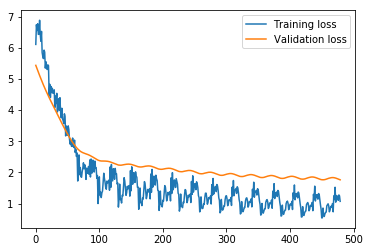

In [19]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()

Test:

In [20]:
with tf.Session() as sess:
    sess.run(init)
    
    correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(label, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, "float"))
    test_text = np.array([text for (text, label) in test])
    test_label = np.array([label for (text, label) in test])
    print("test set accuracy: ", accuracy.eval({text: test_text, label: test_label}))

test set accuracy:  0.10699589
